<h1 align="center"> Auto insurance - Pricing dataset </h1>

In [4]:
!pip install seaborn

In [1]:
import numpy as np
import pandas as pd
import re

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy.stats

In [3]:
import warnings
warnings.filterwarnings("ignore")

## Goal of the project : 
The objective of calculating an annual third-party premium (material + bodily) for the 36,311 contracts in the 2011 pricing dataset :
Indeed, we will determine the cost of third-party insurance for each contract on an annual basis. This premium is intended to cover material and bodily damages caused to third parties in the event of an accident where the insured party is at fault.


#### Step 1. Data cleaning

In [4]:
# Load the pricing dataset
pricing_data = pd.read_csv('pricing.csv', sep=',')

In [5]:
# Display the first few rows of the pricing dataset to understand its structure
print("\nPricing Dataset:")
pricing_data.head()


Pricing Dataset:


,Unnamed: 0,PolNum,CalYear,Gender,Type,Category,Occupation,Age,Group1,Bonus,Poldur,Value,Adind,SubGroup2,Group2,Density
0,1,200325695,2011,Male,C,Medium,Housewife,47,15,90,6,1120,1,R22,R,270.463233
1,2,200325696,2011,Male,D,Large,Housewife,46,9,-30,1,28170,1,L16,L,66.467827
2,3,200325697,2011,Male,F,Large,Employed,52,11,70,7,23505,1,Q36,Q,206.230276
3,4,200325698,2011,Male,B,Large,Retired,61,15,-50,12,7610,0,Q4,Q,138.506671
4,5,200325699,2011,Female,B,Large,Employed,34,5,-50,3,10725,1,L39,L,68.909351


The pricing dataset contains:

Contains data from 36,311 insurance contracts for the year 2011.
Similar to the training dataset, but without the variables related to historical claim data.
Each row represents a unique insurance contract.

| Column     | Description                                                                  |
|------------|------------------------------------------------------------------------------|
| PolNum     | Contract number                                                              |
| CalYear    | Subscription year                                                            |
| Gender     | Gender of the vehicle driver                                                 |
| Type       | Type of car                                                                  |
| Category   | Car category                                                                 |
| Occupation | Driver's occupation                                                          |
| Age        | Driver's age                                                                 |
| Group1     | Car group                                                                    |
| Bonus      | Bonus-Malus (a discount or surcharge applied based on the claims history)   |
| Poldur     | Age of the insurance contract                                                |
| Value      | Value of the insured vehicle                                                 |
| Adind      | Indicator for material coverage                                              |
| SubGroup2  | Driver's home sub-region                                                     |
| Group2     | Driver's home region                                                         |
| Density    | Population density                                                           |                        |


In [6]:
# Get general information on the dataset (ncol, nrow, nbr missing values, dtypes)
pricing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36311 entries, 0 to 36310
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  36311 non-null  int64  
 1   PolNum      36311 non-null  int64  
 2   CalYear     36311 non-null  int64  
 3   Gender      36311 non-null  object 
 4   Type        36311 non-null  object 
 5   Category    36311 non-null  object 
 6   Occupation  36311 non-null  object 
 7   Age         36311 non-null  int64  
 8   Group1      36311 non-null  int64  
 9   Bonus       36311 non-null  int64  
 10  Poldur      36311 non-null  int64  
 11  Value       36311 non-null  int64  
 12  Adind       36311 non-null  int64  
 13  SubGroup2   36311 non-null  object 
 14  Group2      36311 non-null  object 
 15  Density     36311 non-null  float64
dtypes: float64(1), int64(9), object(6)
memory usage: 4.4+ MB


In [7]:
# Check for missing values in the pricing dataset
print("\nMissing Values in Pricing Dataset:")
print(pricing_data.isnull().sum())


Missing Values in Pricing Dataset:
Unnamed: 0    0
PolNum        0
CalYear       0
Gender        0
Type          0
Category      0
Occupation    0
Age           0
Group1        0
Bonus         0
Poldur        0
Value         0
Adind         0
SubGroup2     0
Group2        0
Density       0
dtype: int64


In [8]:
# Check for duplicates in the pricing dataset
print("\nDuplicates in Pricing Dataset:")
print(pricing_data.duplicated().sum())


Duplicates in Pricing Dataset:
0


In [9]:
# Summary statistics of the pricing dataset
print("\nSummary Statistics of Pricing Dataset:")
pricing_data.describe()


Summary Statistics of Pricing Dataset:


,Unnamed: 0,PolNum,CalYear,Age,Group1,Bonus,Poldur,Value,Adind,Density
count,36311.000000,3.631100e+04,36311.0,36311.000000,36311.000000,36311.000000,36311.000000,36311.000000,36311.000000,36311.000000
mean,18156.000000,2.003507e+08,2011.0,41.186087,10.712153,-6.594145,5.559335,16518.524689,0.518465,116.666024
std,10482.227149,1.446972e+04,0.0,14.306933,4.690578,49.074019,4.626096,10528.519190,0.499666,79.787179
min,1.000000,2.003257e+08,2011.0,18.000000,1.000000,-50.000000,0.000000,1005.000000,0.000000,14.377142
25%,9078.500000,2.003381e+08,2011.0,30.000000,7.000000,-40.000000,2.000000,8400.000000,0.000000,50.351845
50%,18156.000000,2.003507e+08,2011.0,40.000000,11.000000,-30.000000,4.000000,14665.000000,1.000000,93.382351
75%,27233.500000,2.003633e+08,2011.0,51.000000,14.000000,10.000000,9.000000,22700.000000,1.000000,171.372936
max,36311.000000,2.003757e+08,2011.0,75.000000,20.000000,150.000000,15.000000,49995.000000,1.000000,297.385170


#### Step 2. Data exploration

In [11]:
# Drop the column named "Unnamed"
pricing_data.drop(columns=["Unnamed: 0"], inplace=True)

##### **1. Univariate Data Analysis**

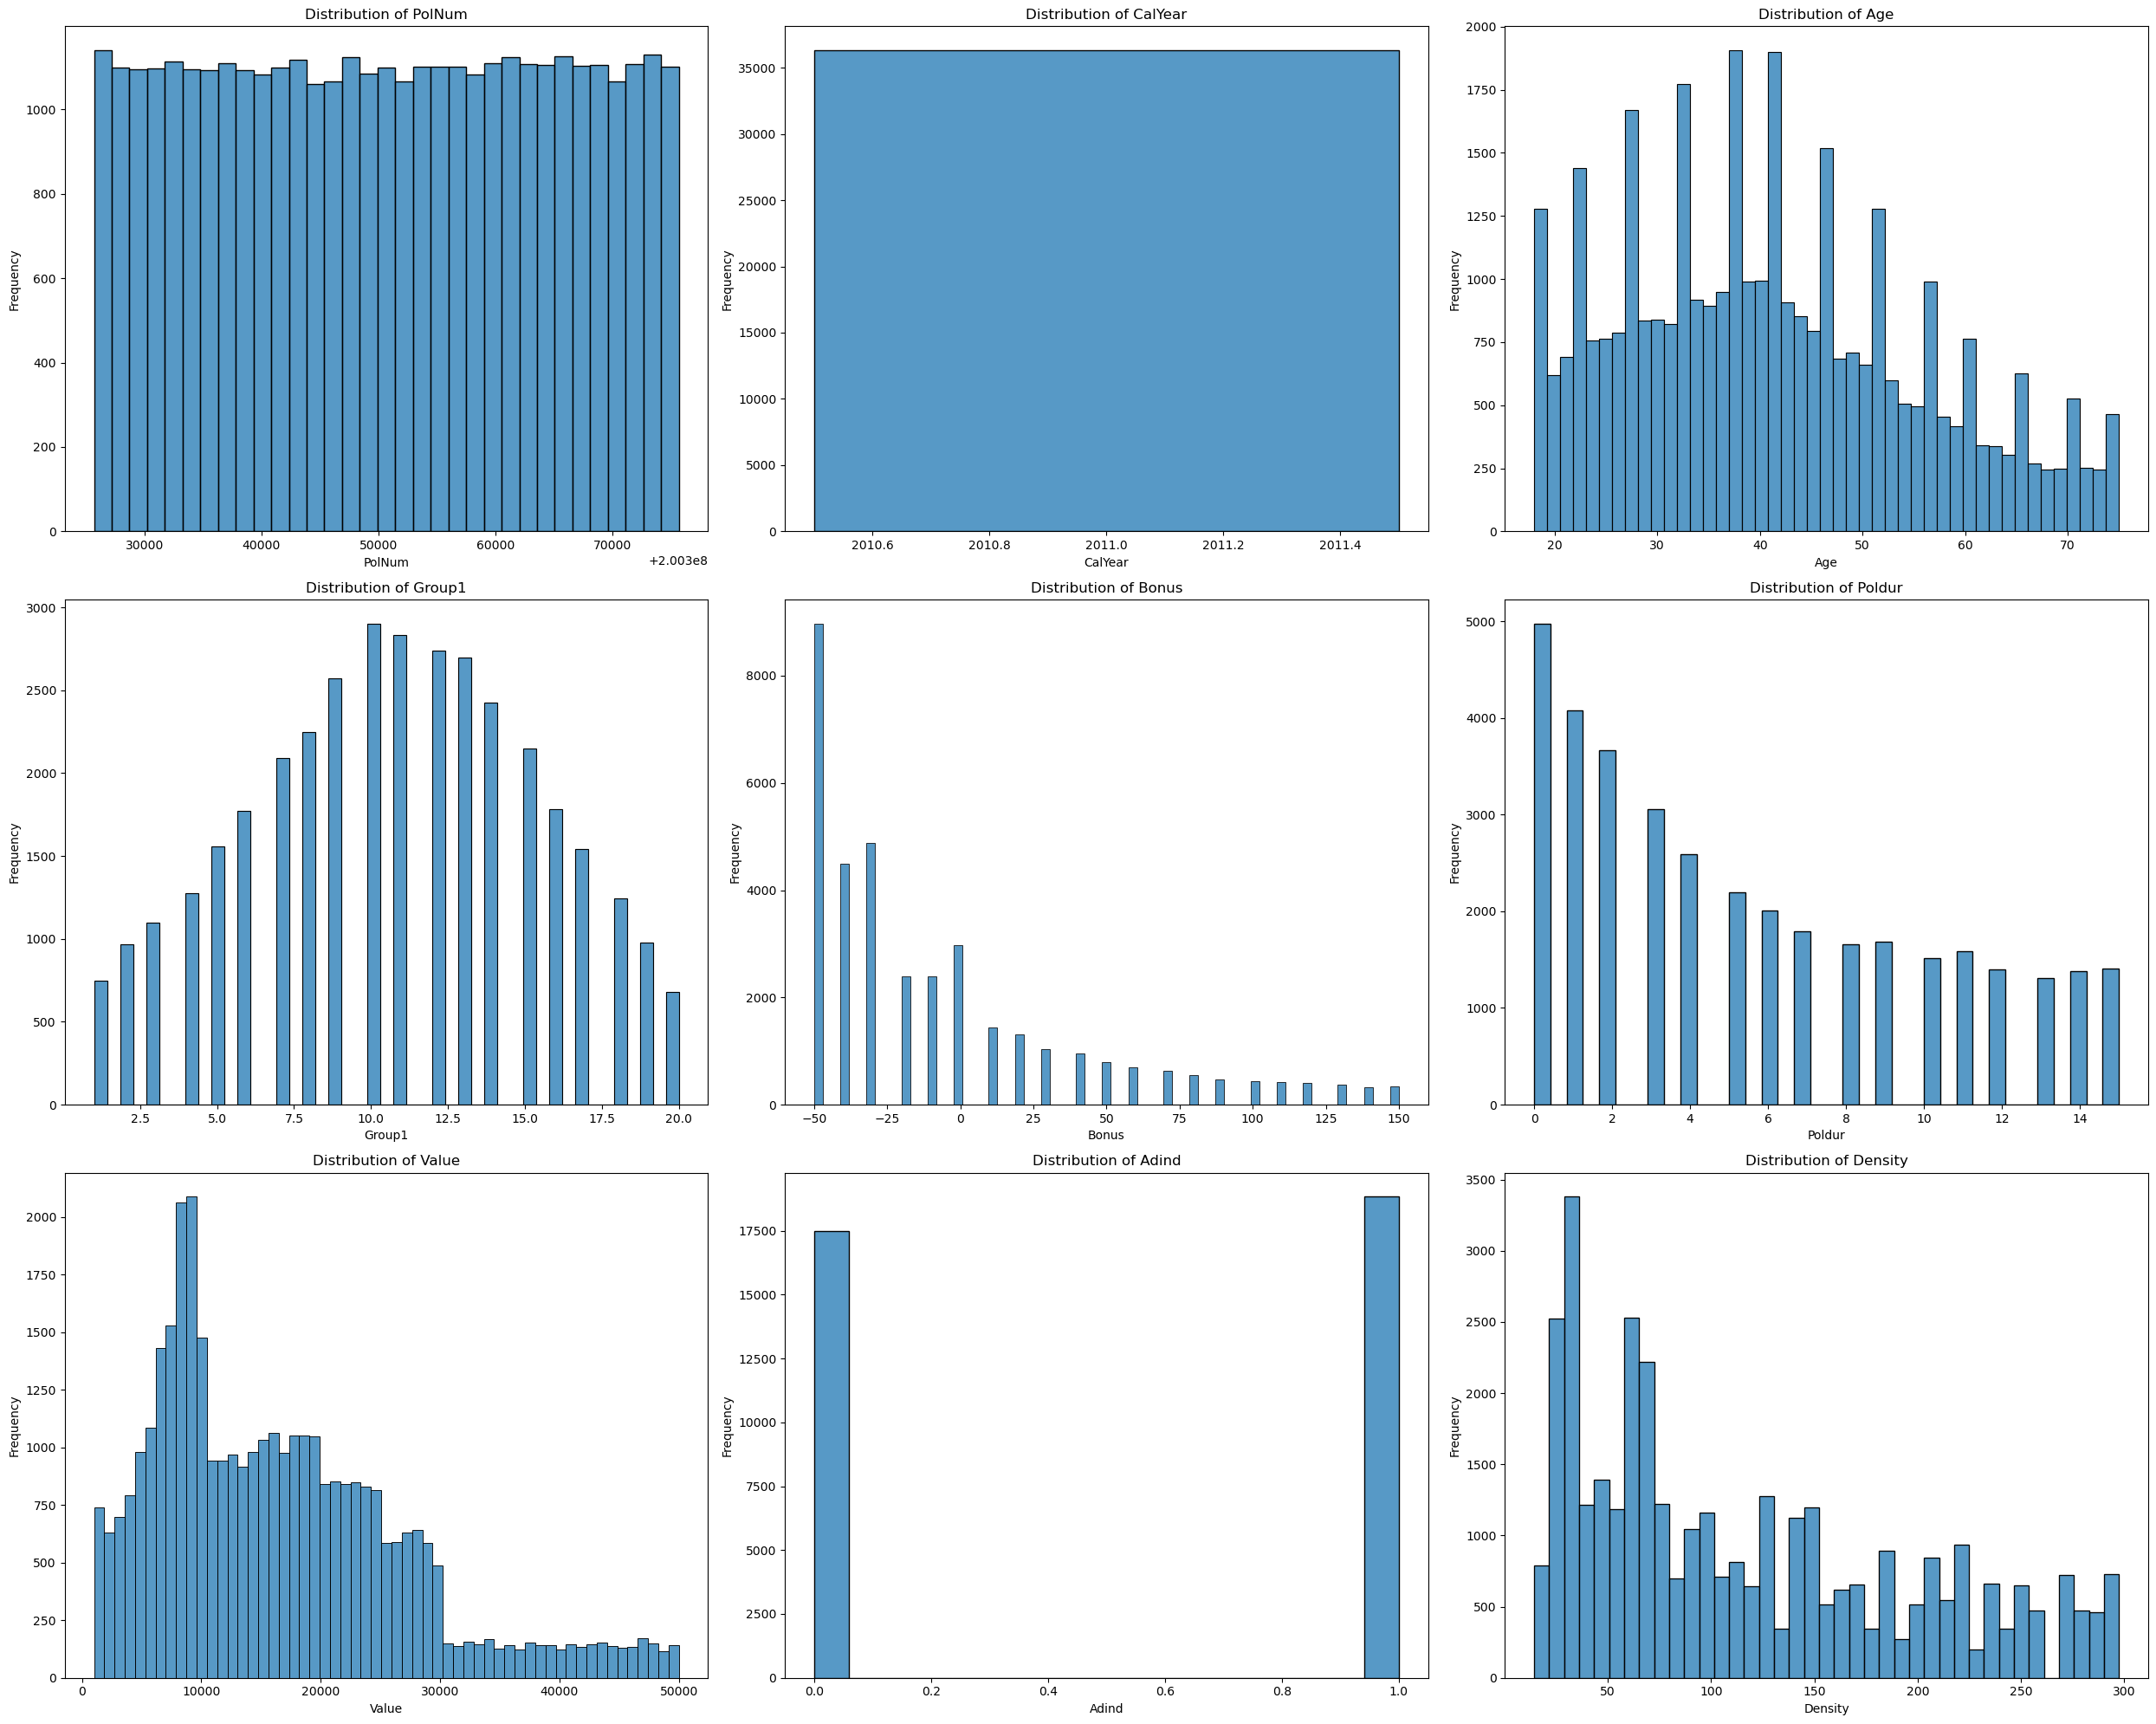

In [12]:
# Univariate analysis for numerical variables
numerical_vars = pricing_data.select_dtypes(include=[np.number]).columns

# Calculate the number of rows and columns for the layout
num_cols = 3  # Number of columns per row
num_rows = (len(numerical_vars) - 1) // num_cols + 1  # Number of rows

# Distribution plots for numerical variables
plt.figure(figsize=(25, 20))
for i, var in enumerate(numerical_vars):
    plt.subplot(num_rows, num_cols, i+1)
    sns.histplot(pricing_data[var], kde=False)
    plt.title(f'Distribution of {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

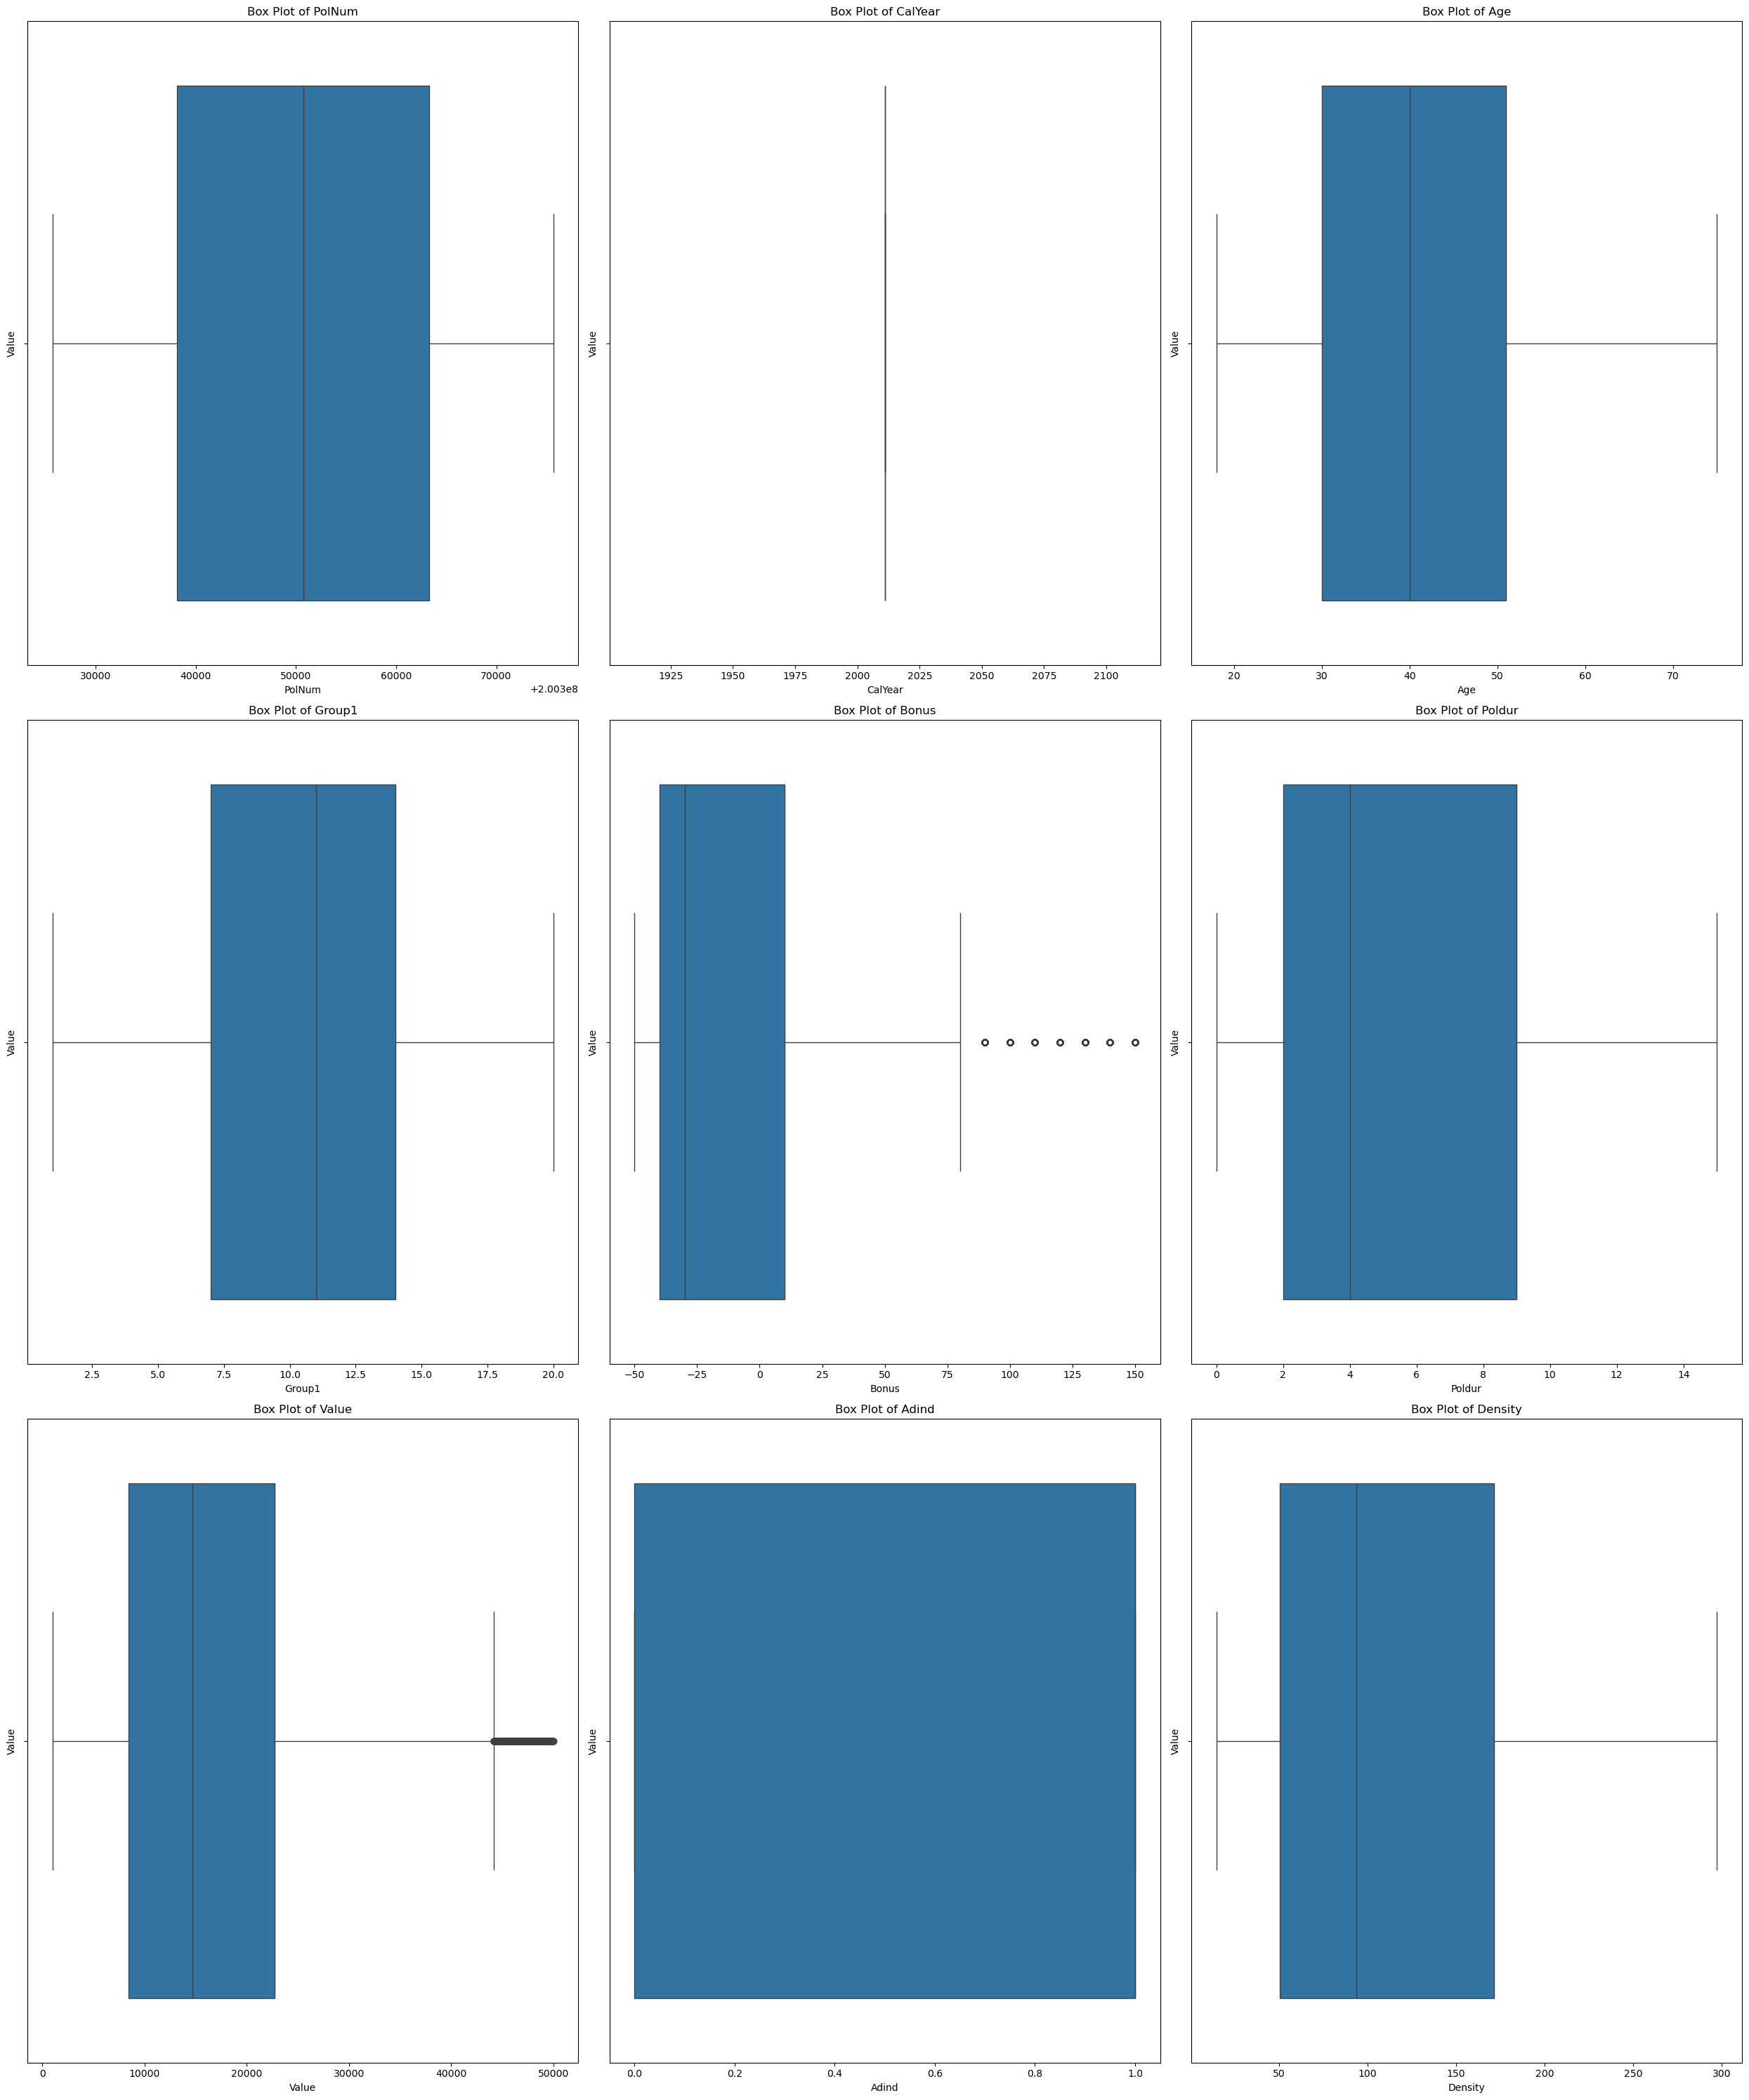

In [13]:
# Univariate analysis for numerical variables
numerical_vars = pricing_data.select_dtypes(include=[np.number]).columns

# Calculate the number of rows and columns for the layout
num_cols = 3  # Number of columns per row
num_rows = (len(numerical_vars) - 1) // num_cols + 1  # Number of rows

# Box plots for numerical variables
plt.figure(figsize=(25, 30))
for i, var in enumerate(numerical_vars):
    plt.subplot(num_rows, num_cols, i+1)
    sns.boxplot(x=var, data=pricing_data)
    plt.title(f'Box Plot of {var}')
    plt.xlabel(var)
    plt.ylabel('Value')
plt.tight_layout()
plt.show()

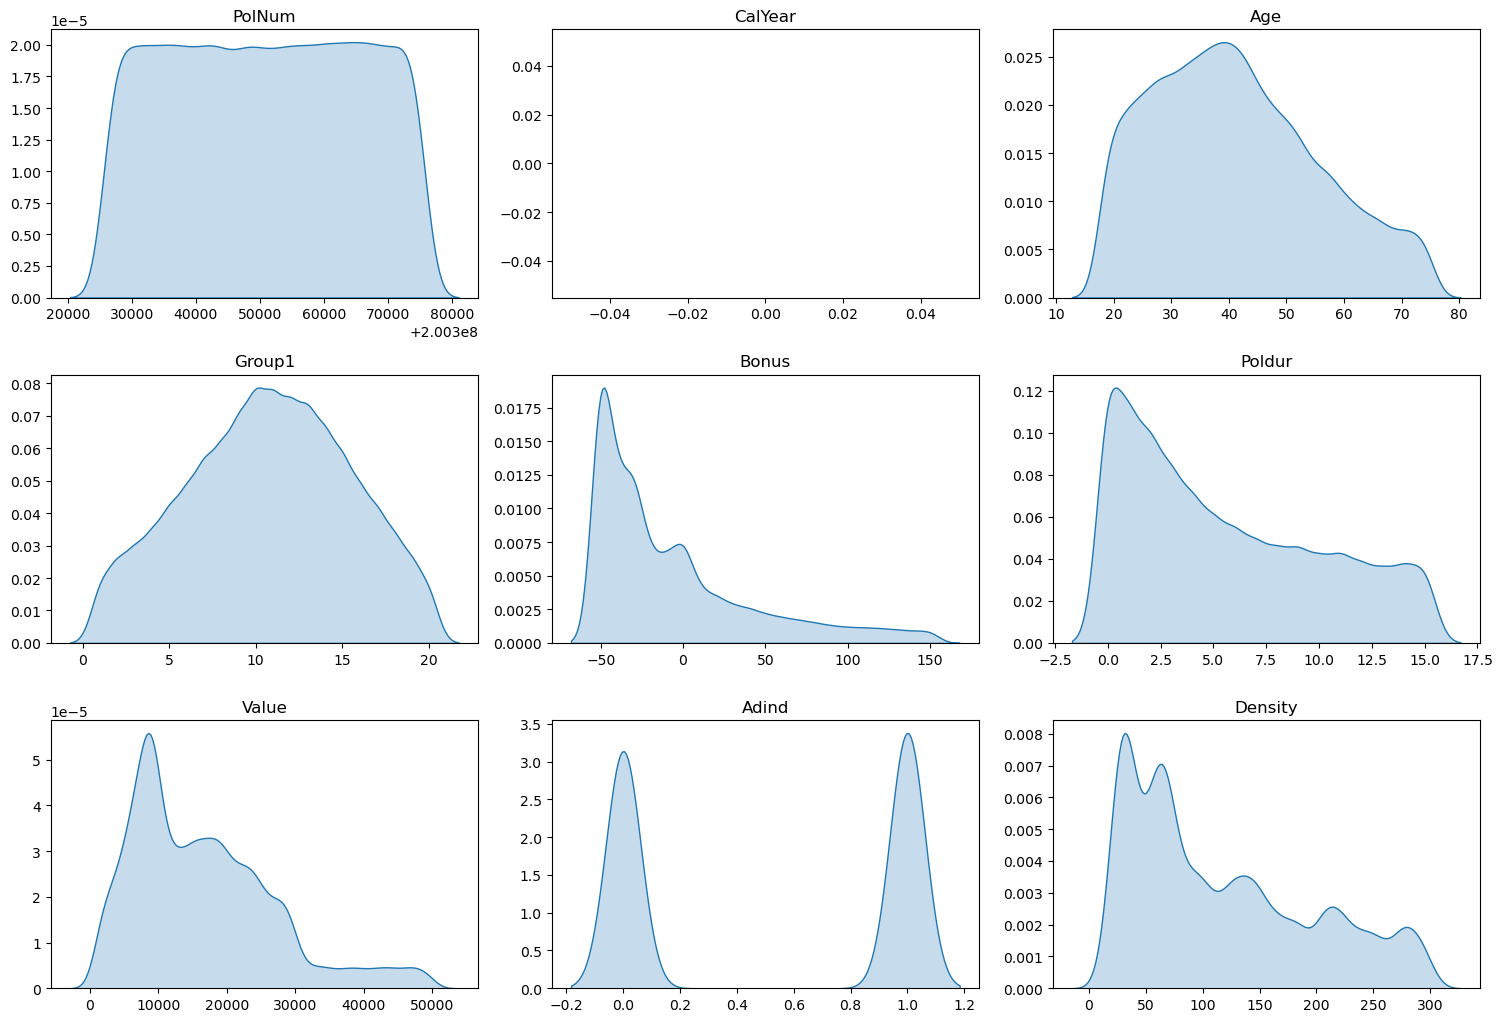

In [14]:
# Determine continuous variables
numerical_vars = pricing_data.select_dtypes(include=[np.number]).columns.tolist()

# Plot KDE plots for continuous variables
plt.figure(figsize=(15, 17))
for c, var in enumerate(numerical_vars):
    plt.subplot(5, 3, c+1)
    sns.kdeplot(data=pricing_data, x=var, fill=True)
    plt.title(str(var))
    plt.xlabel("")
    plt.ylabel("")

plt.tight_layout()
plt.show()


Interpretations : 

PolNum: Have a unimodal distribution with a peak (which reflect the group in 2011).


Age: Shows a distribution that at skewed to thlefght, indicating a younger population, with fewer older indivualsid (between 30 and 50 years old approxs.

Group1: The distribution is roughly ngularaped, possibly indicating a uniform distribution across the range, with a peak at center he  (peak corresponds to the group of cars for which we have the highest number of contra.ory)

Bonus: This plot sholeftright skew, indicating that bonuses are typy icall(disco s) y lower with a few larger bonuses being  lesscommon.

Poldur:  leftr right-skewed distribution, implying that shorter policy durations are more common nthan loger ones.

Value: Exhibi leflong right tail, indicating a concentration of lower values with some higheas values s eme values.

Adind: This variable has a bimodal distribution with two peaks at the extremes and a lower density in the middle, which might suggest two distinct grooups or behavirs in the data.

Density: Shows seve left ks and a right skew, which could imply multiple modies of density wth
ation at the low end.

In [15]:
# Handling outliers
# Define the list of numerical columns
numerical_cols = ['Bonus']  # Not sure to add or not column bonus 

# Iterate over each numerical column
for col in numerical_cols:
    # Calculate the IQR
    Q1 = pricing_data[col].quantile(0.25)
    Q3 = pricing_data[col].quantile(0.75)
    IQR = Q3 - Q1

    # Define the bounds for the outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Cap the outliers
    pricing_data[col + '_Capped'] = pricing_data[col].apply(lambda x: min(max(x, lower_bound), upper_bound))

In [16]:
# Summary statistics of the training dataset
print("\nSummary Statistics of pricing Dataset:")
pricing_data.describe()


Summary Statistics of Training Dataset:


,PolNum,CalYear,Age,Group1,Bonus,Poldur,Value,Adind,Density,Bonus_Capped
count,3.631100e+04,36311.0,36311.000000,36311.000000,36311.000000,36311.000000,36311.000000,36311.000000,36311.000000,36311.000000
mean,2.003507e+08,2011.0,41.186087,10.712153,-6.594145,5.559335,16518.524689,0.518465,116.666024,-9.088706
std,1.446972e+04,0.0,14.306933,4.690578,49.074019,4.626096,10528.519190,0.499666,79.787179,42.814053
min,2.003257e+08,2011.0,18.000000,1.000000,-50.000000,0.000000,1005.000000,0.000000,14.377142,-50.000000
25%,2.003381e+08,2011.0,30.000000,7.000000,-40.000000,2.000000,8400.000000,0.000000,50.351845,-40.000000
50%,2.003507e+08,2011.0,40.000000,11.000000,-30.000000,4.000000,14665.000000,1.000000,93.382351,-30.000000
75%,2.003633e+08,2011.0,51.000000,14.000000,10.000000,9.000000,22700.000000,1.000000,171.372936,10.000000
max,2.003757e+08,2011.0,75.000000,20.000000,150.000000,15.000000,49995.000000,1.000000,297.385170,85.000000


In [17]:
#Second method : replacing by the median value : 

# Select only numeric columns
numeric_cols = pricing_data.select_dtypes(include=['number'])  # Select only numeric columns

# Outlier detection using IQR
Q1 = numeric_cols.quantile(0.25)
Q3 = numeric_cols.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 0.5 * IQR
upper_bound = Q3 + 0.5 * IQR

# Identify outliers
outliers = (numeric_cols < lower_bound) | (numeric_cols > upper_bound)

# Handling outliers: Replace outliers with the median value
pricing_data_no_outliers = numeric_cols.mask(outliers, numeric_cols.median(), axis=0)

# Fill remaining NaN values with median column-wise
pricing_data_no_outliers = pricing_data_no_outliers.fillna(pricing_data_no_outliers.median())

# Summary statistics of the training dataset
print("\nSummary Statistics of pricing Dataset:")
pricing_data_no_outliers.describe()


Summary Statistics of pricing Dataset:


,PolNum,CalYear,Age,Group1,Bonus,Poldur,Value,Adind,Density,Bonus_Capped
count,3.631100e+04,36311.0,36311.000000,36311.000000,36311.000000,36311.000000,36311.000000,36311.000000,36311.000000,36311.000000
mean,2.003507e+08,2011.0,38.683126,10.775936,-26.638484,4.429099,14109.314877,0.518465,93.207750,-26.638484
std,1.446972e+04,0.0,10.177286,3.310429,21.520099,3.499047,7172.127162,0.499666,56.694873,21.520099
min,2.003257e+08,2011.0,20.000000,4.000000,-50.000000,0.000000,1250.000000,0.000000,14.377142,-50.000000
25%,2.003381e+08,2011.0,31.000000,9.000000,-40.000000,2.000000,8480.000000,0.000000,50.351845,-40.000000
50%,2.003507e+08,2011.0,38.000000,11.000000,-30.000000,4.000000,13197.500000,1.000000,76.505375,-30.000000
75%,2.003633e+08,2011.0,46.000000,13.000000,-10.000000,7.000000,19387.500000,1.000000,129.855235,-10.000000
max,2.003757e+08,2011.0,61.000000,17.000000,30.000000,12.000000,29850.000000,1.000000,225.141742,30.000000


In [18]:
# Select categorical variables
categorical_var = pricing_data.select_dtypes(include=["object"]).columns.to_list()
# Number of unique values per variable
pricing_data[categorical_var].nunique()

Gender          2
Type            6
Category        3
Occupation      5
SubGroup2     471
Group2         10
dtype: int64

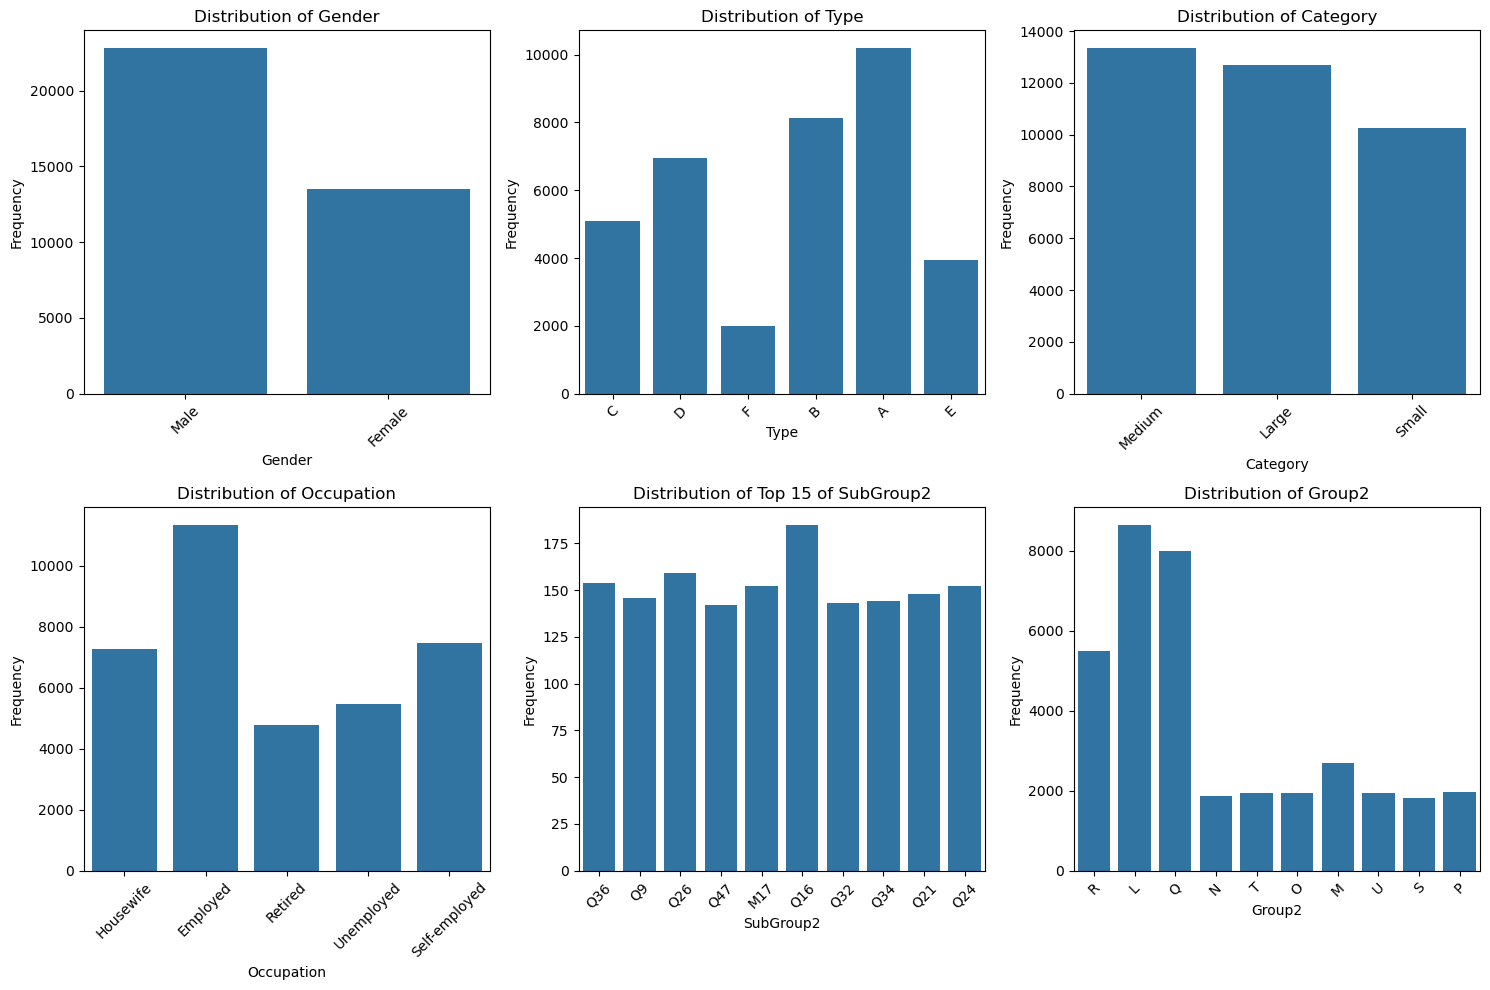

In [19]:
# Univariate analysis for categorical variables
categorical_vars = pricing_data.select_dtypes(include=['object']).columns

# Calculate the number of rows and columns for the layout
num_cols = 3  # Number of columns per row
num_rows = (len(categorical_vars) - 1) // num_cols + 1  # Number of rows

# Plot categorical variables using count plots
plt.figure(figsize=(15, 10))
for i, var in enumerate(categorical_vars):
    if var == 'SubGroup2':
        top_categories = pricing_data[var].value_counts().nlargest(10).index
        data_subset = pricing_data[pricing_data[var].isin(top_categories)]
        title = f'Distribution of Top 15 of {var}'
    else:
        data_subset = pricing_data
        title = f'Distribution of {var}'
    plt.subplot(num_rows, num_cols, i+1)
    sns.countplot(x=var, data=data_subset)
    plt.title(title)
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

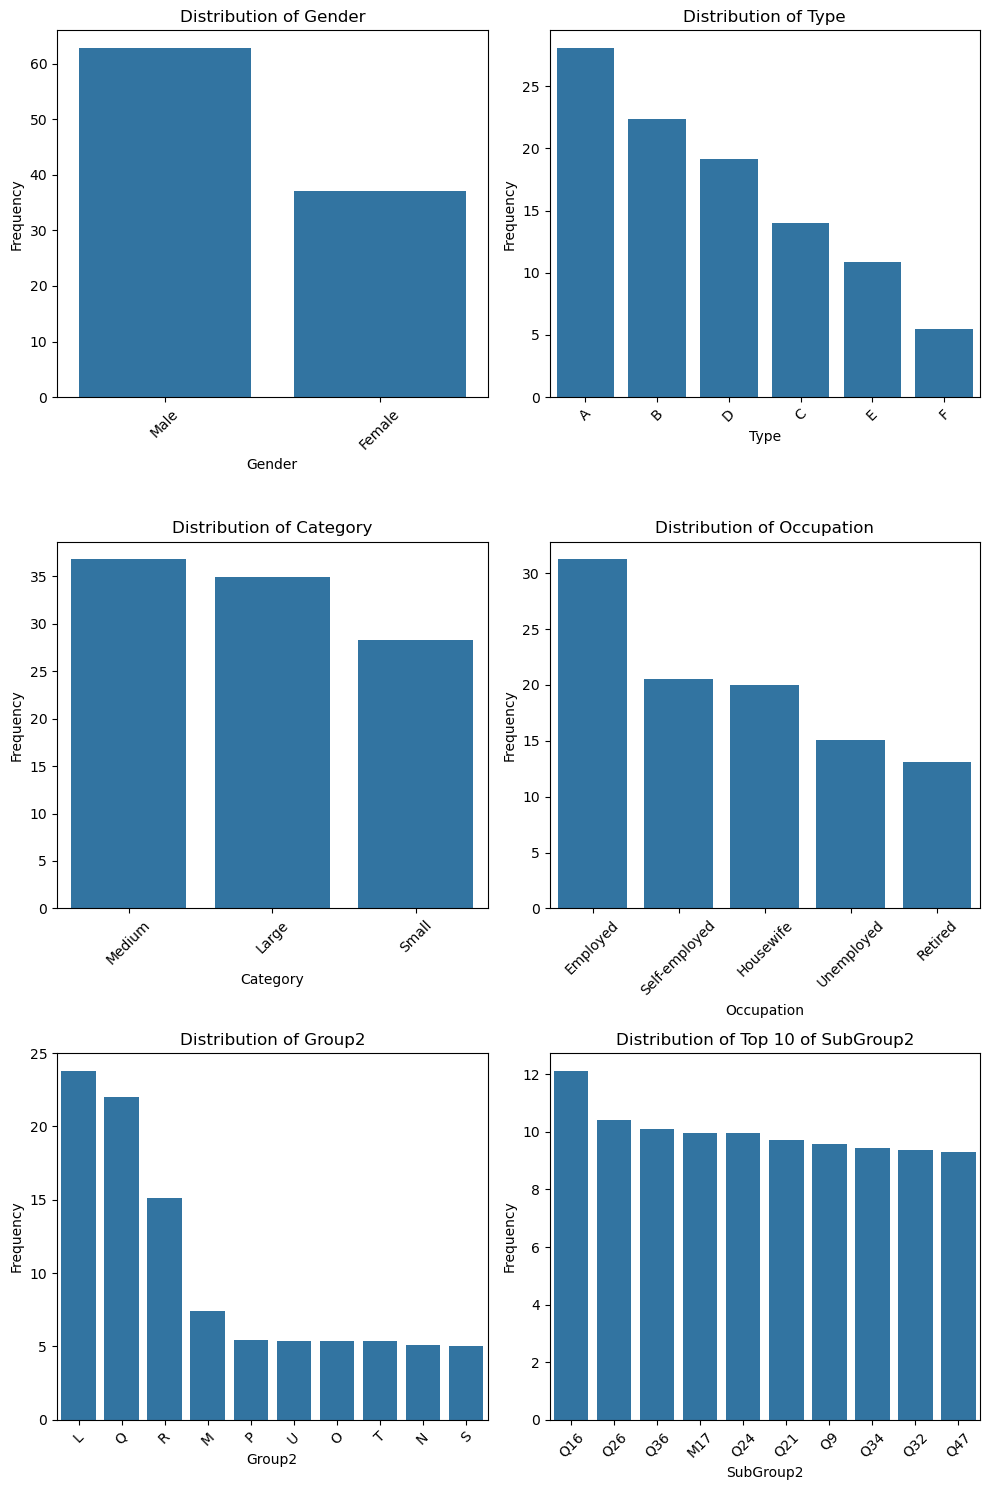

In [20]:
# Select categorical variables with a small number of unique values
df_barplot = pricing_data[["Gender", "Type", "Category", "Occupation", "Group2", "SubGroup2"]]

# Create barplot with frequency for each variable
plt.figure(figsize=(10, 15))

for c, var in enumerate(df_barplot.columns):
    if var == 'SubGroup2':
        top_categories = pricing_data[var].value_counts().nlargest(10).index
        data_subset = pricing_data[pricing_data[var].isin(top_categories)]
        title = f'Distribution of Top 10 of {var}'
    else:
        data_subset = pricing_data
        title = f'Distribution of {var}'

    # Compute frequency of each unique value
    df = data_subset[var].value_counts(normalize=True).to_frame("frequency").reset_index()
    df["frequency"] *= 100

    # Plot the barplot
    plt.subplot(3, 2, c+1)
    sns.barplot(data=df, x=var, y="frequency")
    plt.title(title)
    plt.xlabel(var)
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [22]:
# Get general information on the dataset (ncol, nrow, nbr missing values, dtypes)
pricing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36311 entries, 0 to 36310
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PolNum        36311 non-null  int64  
 1   CalYear       36311 non-null  int64  
 2   Gender        36311 non-null  object 
 3   Type          36311 non-null  object 
 4   Category      36311 non-null  object 
 5   Occupation    36311 non-null  object 
 6   Age           36311 non-null  int64  
 7   Group1        36311 non-null  int64  
 8   Bonus         36311 non-null  int64  
 9   Poldur        36311 non-null  int64  
 10  Value         36311 non-null  int64  
 11  Adind         36311 non-null  int64  
 12  SubGroup2     36311 non-null  object 
 13  Group2        36311 non-null  object 
 14  Density       36311 non-null  float64
 15  Bonus_Capped  36311 non-null  float64
dtypes: float64(2), int64(8), object(6)
memory usage: 4.4+ MB


In [23]:
# Get general information on the dataset (ncol, nrow, nbr missing values, dtypes)
pricing_data.isnull().sum()

PolNum          0
CalYear         0
Gender          0
Type            0
Category        0
Occupation      0
Age             0
Group1          0
Bonus           0
Poldur          0
Value           0
Adind           0
SubGroup2       0
Group2          0
Density         0
Bonus_Capped    0
dtype: int64

##### **2. Multivariate Data Analysis**

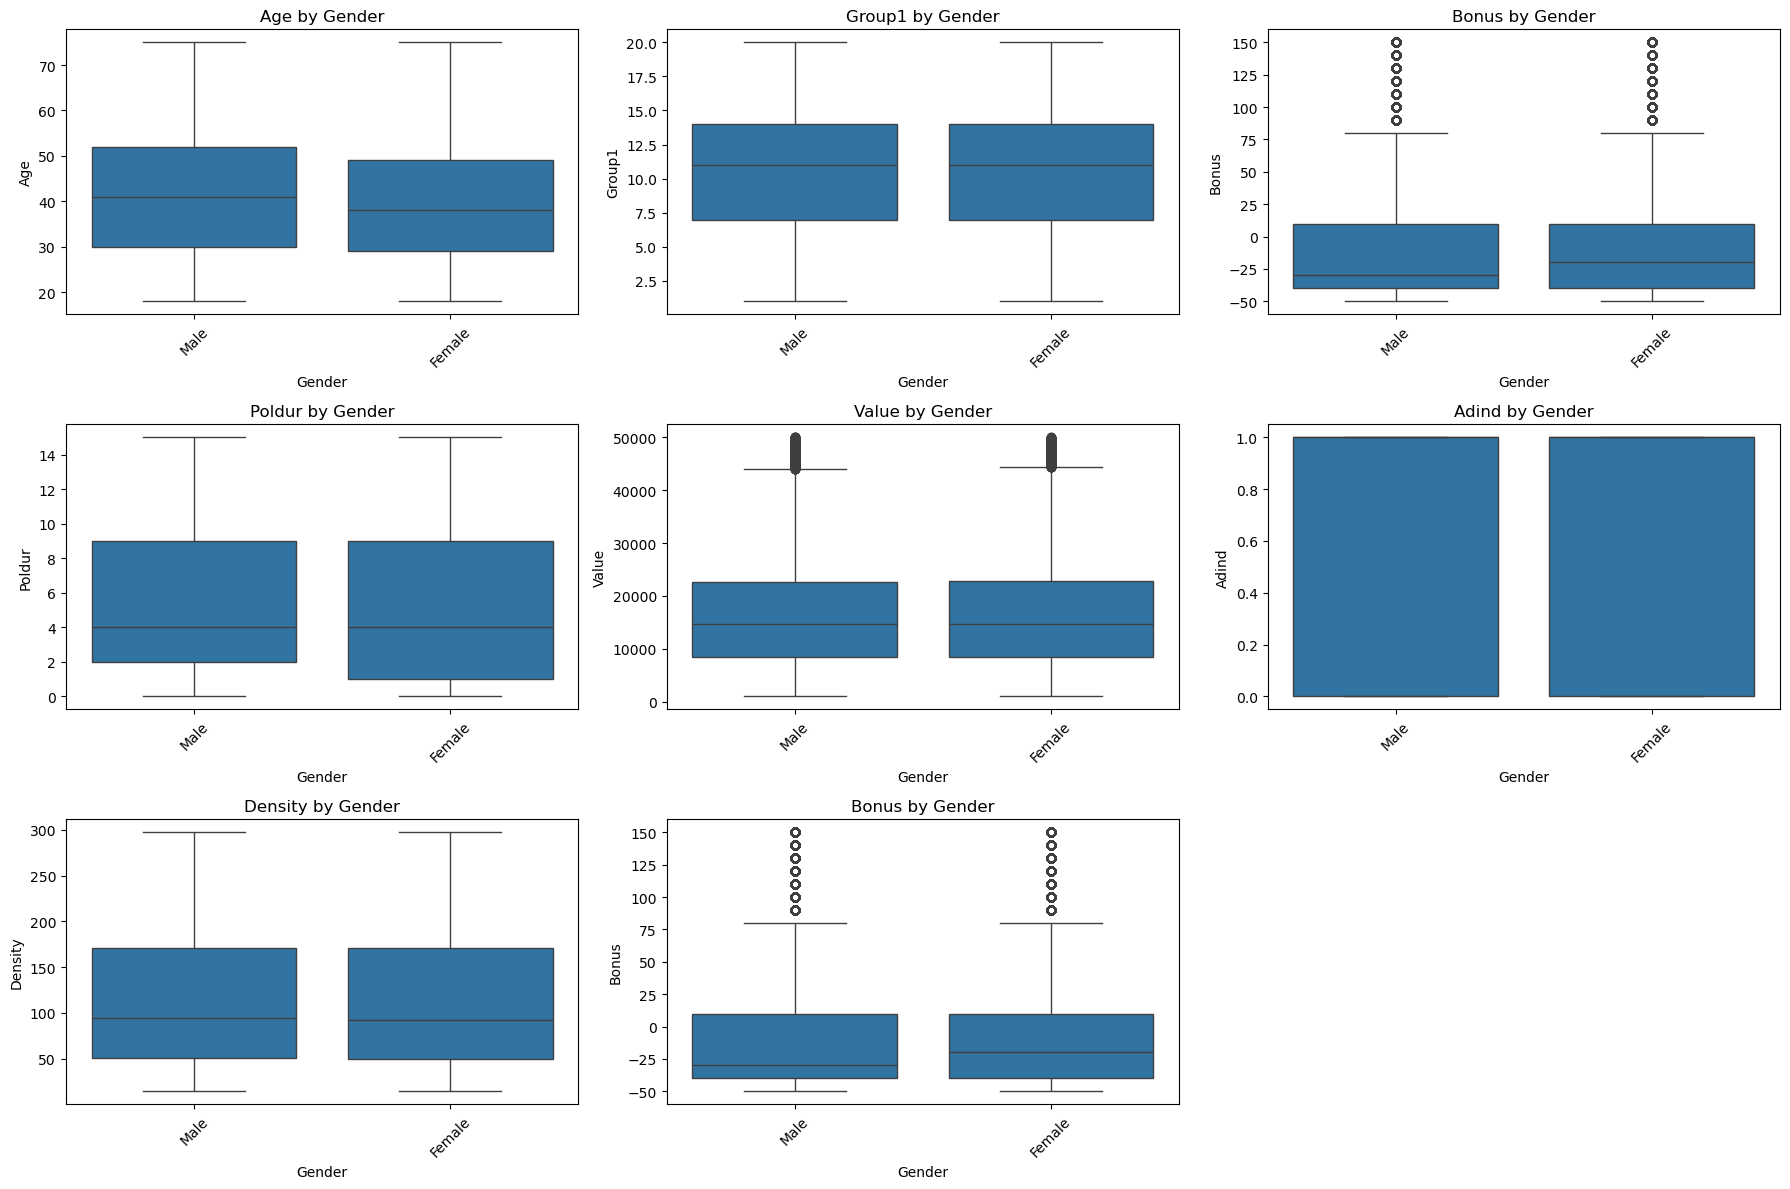

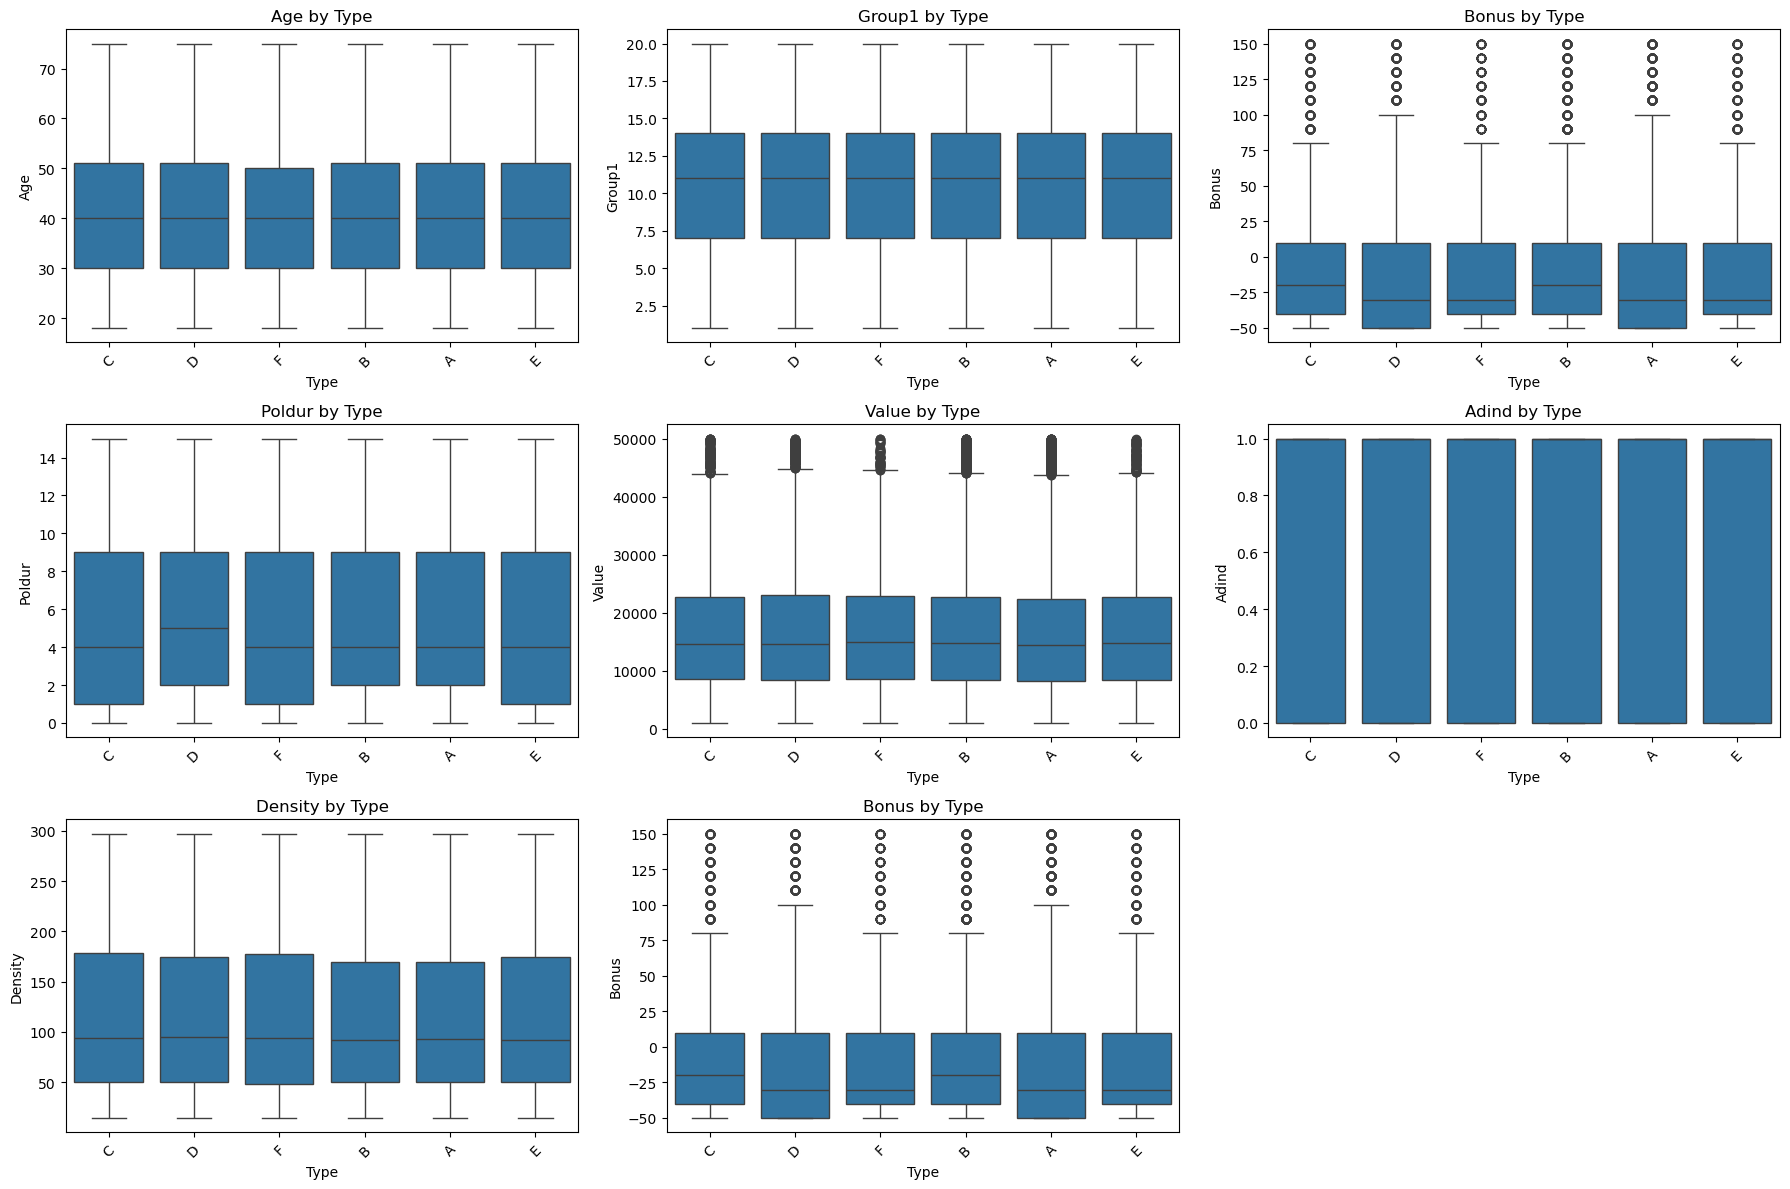

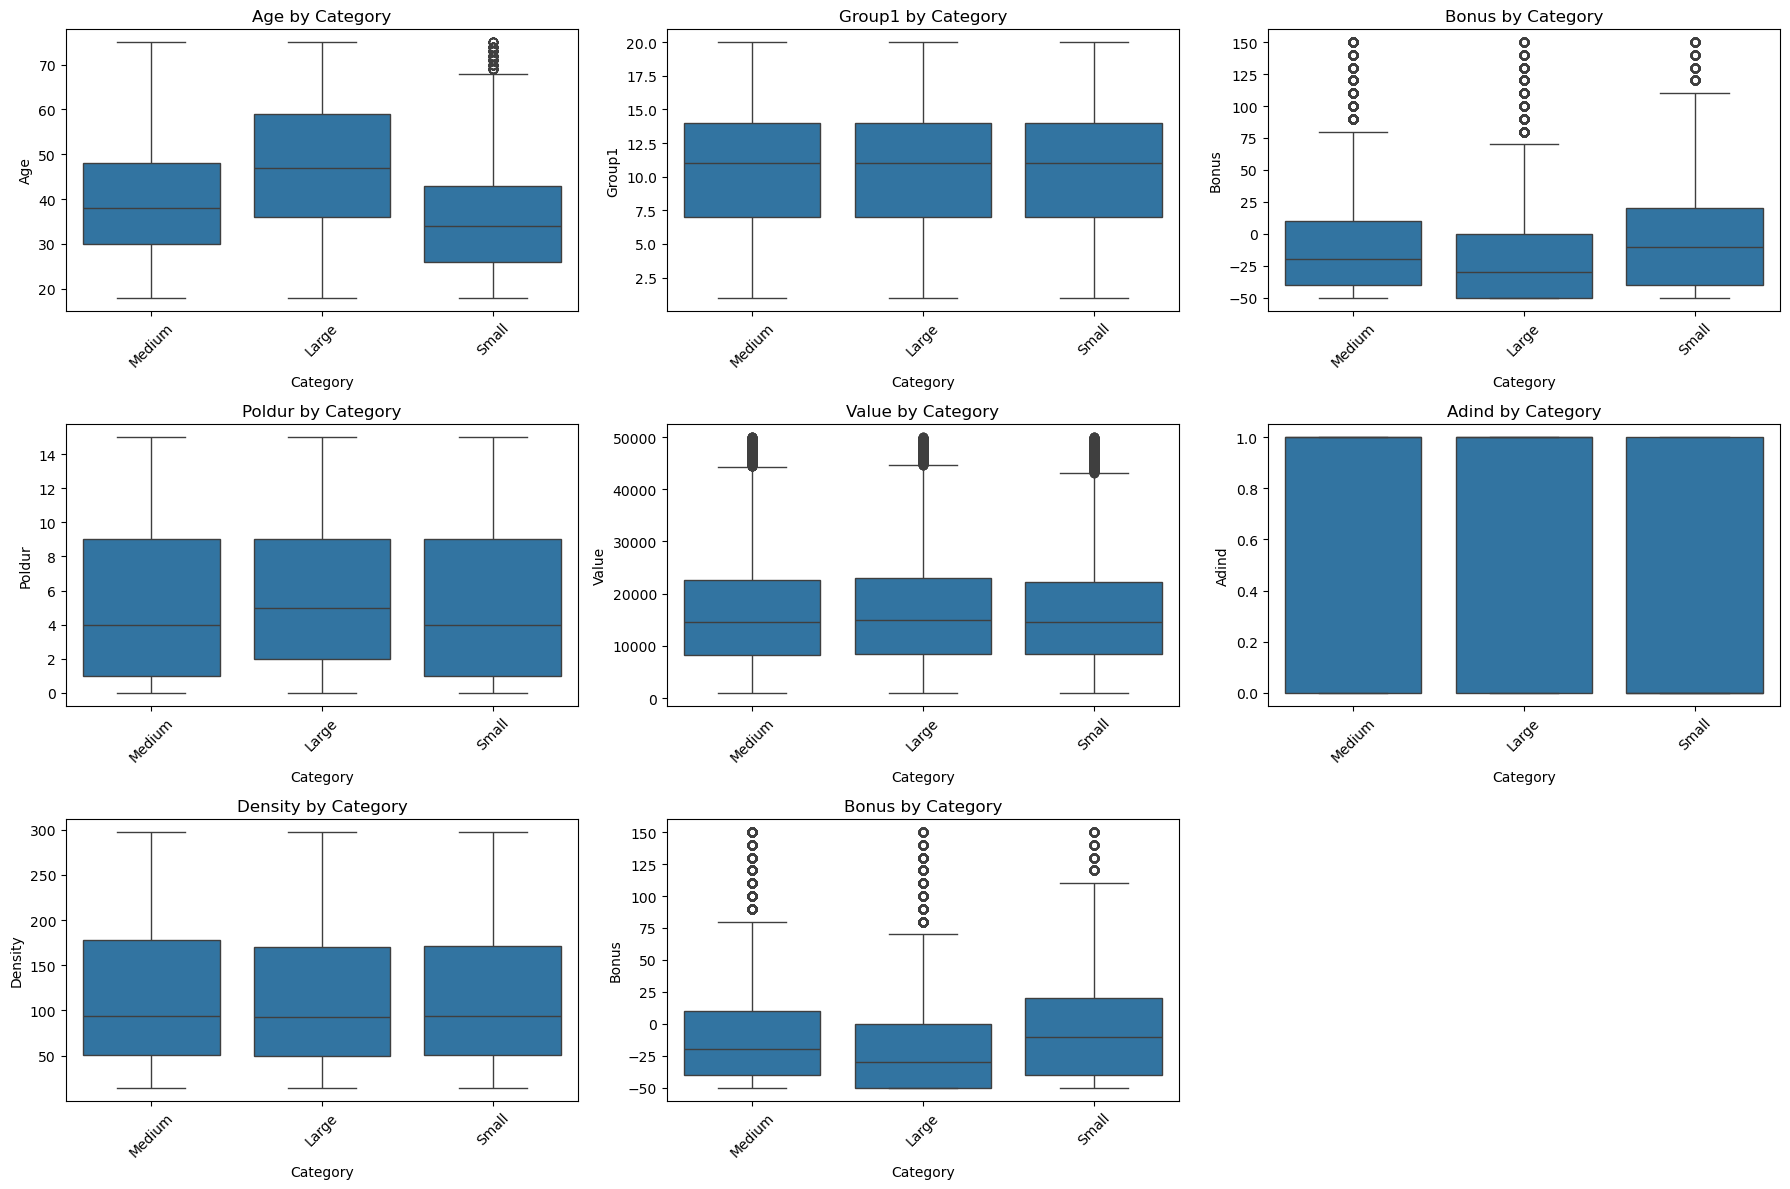

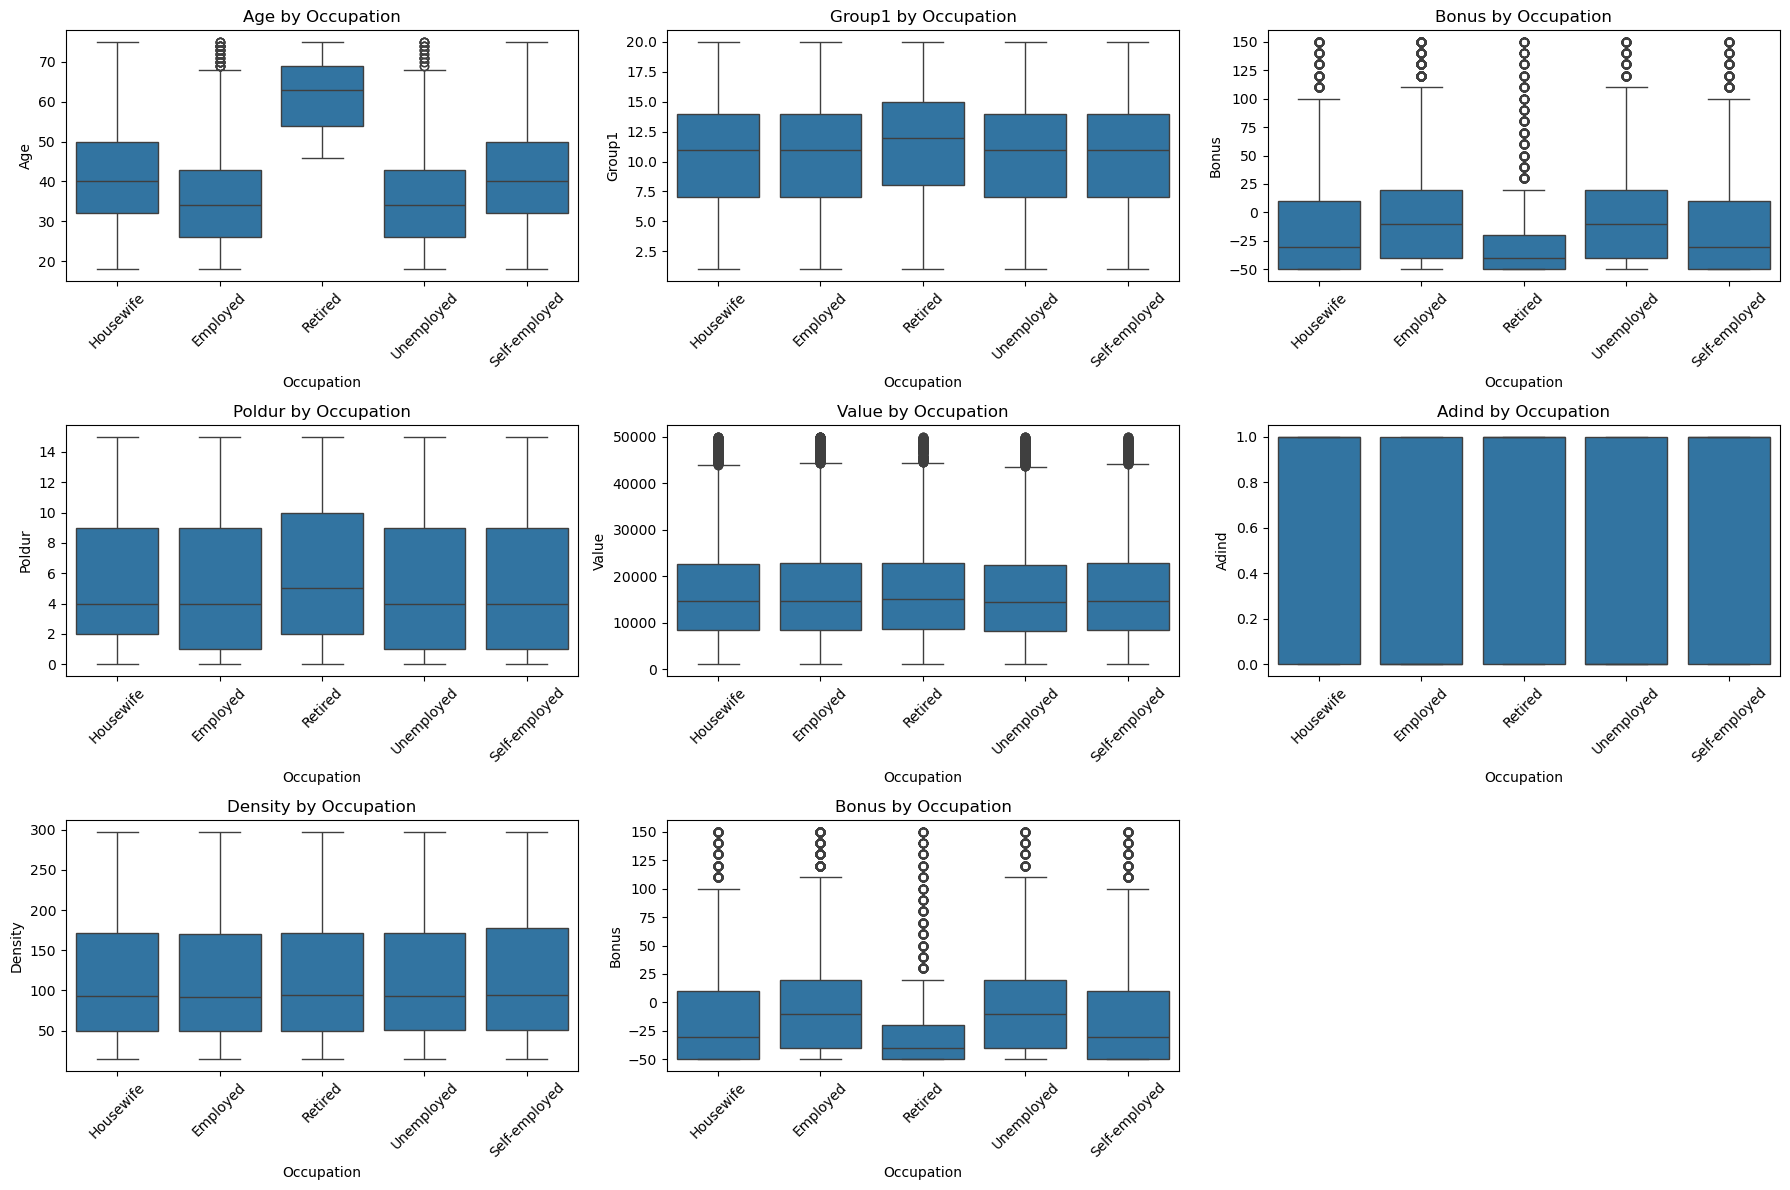

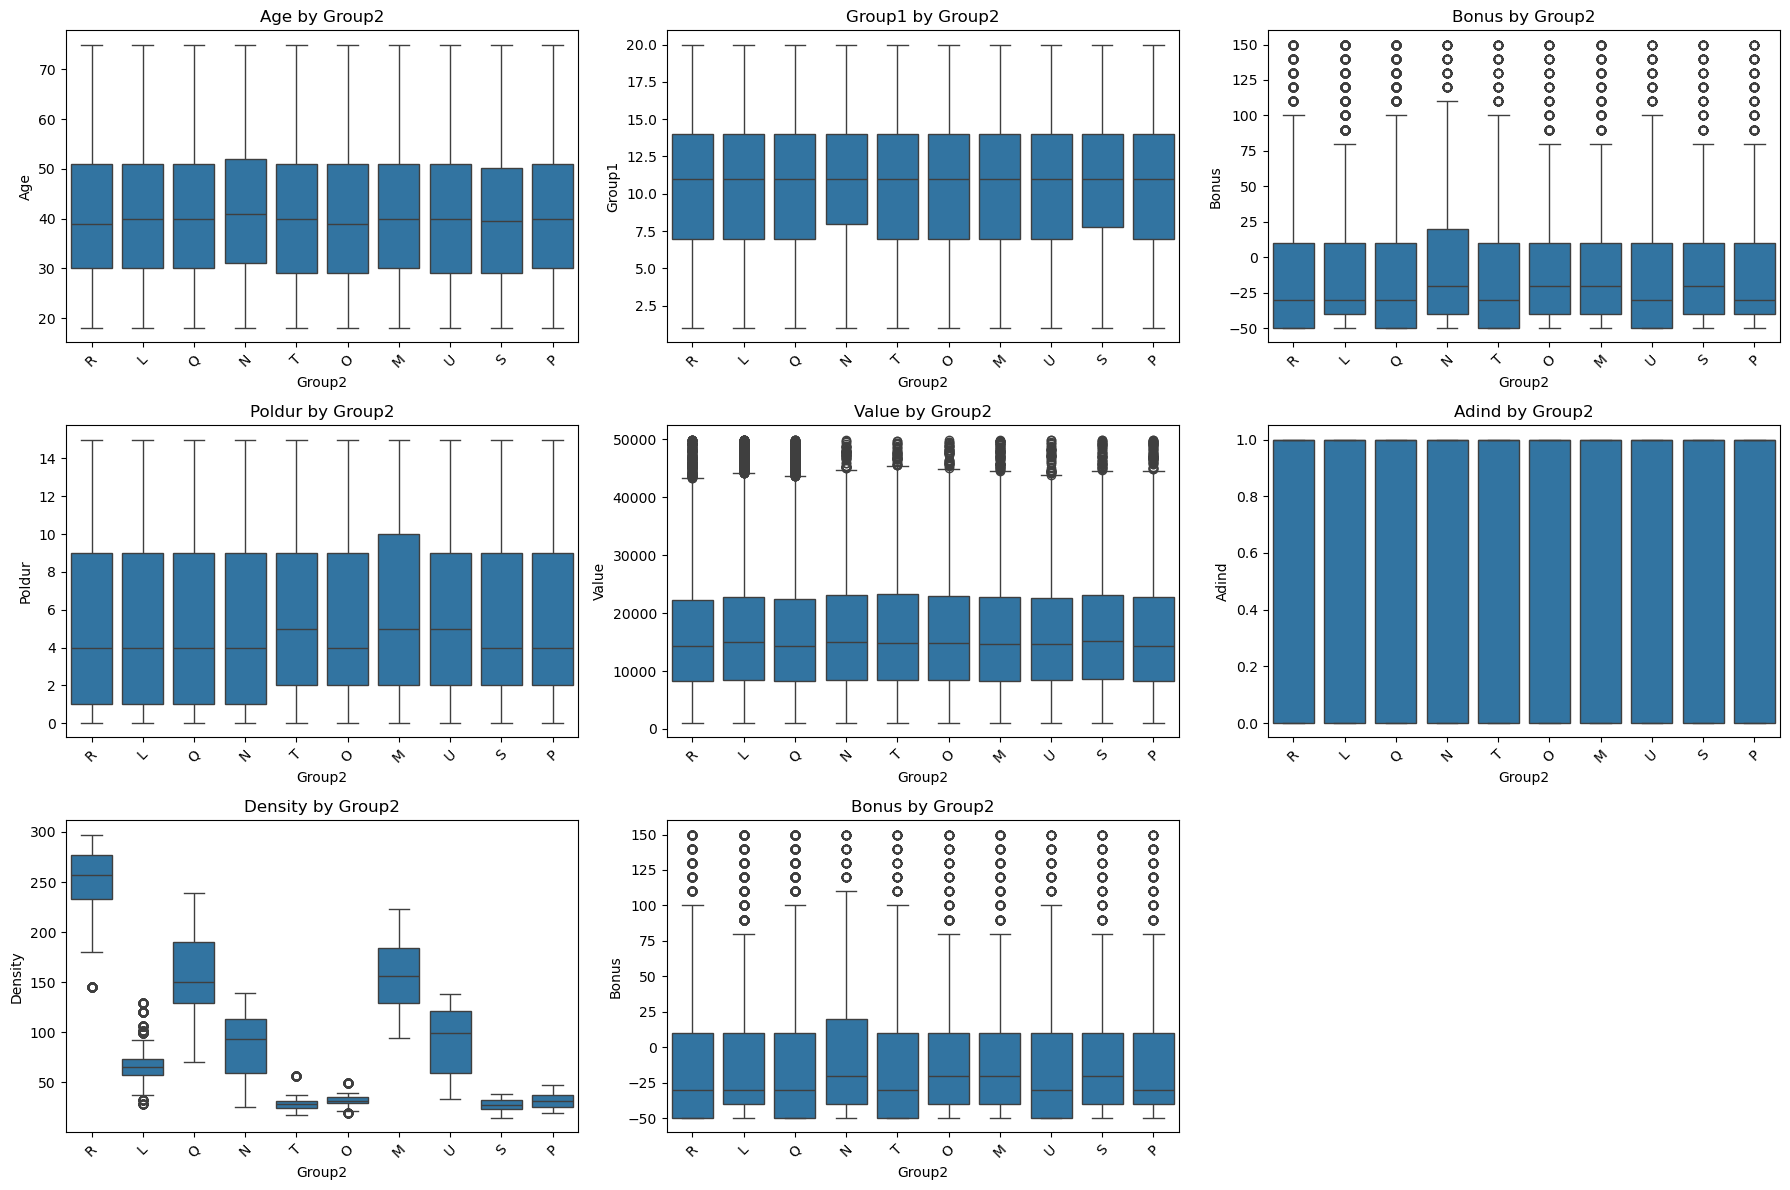

In [24]:
#Categorical and Continuous
# Select continuous variables
continuous_vars = ['Age', 'Group1', 'Bonus', 'Poldur', 'Value', 'Adind', 'Density', 'Bonus']

# Select categorical variables
categorical_vars = ['Gender', 'Type', 'Category', 'Occupation', 'Group2']

# Calculate the number of rows and columns needed for the layout
num_cols = 3  # Number of columns per row
num_rows = (len(continuous_vars) - 1) // num_cols + 1  # Number of rows

# Visualize the relationship between each continuous variable and each categorical variable
for cat_var in categorical_vars:
    plt.figure(figsize=(18, 12))
    for i, cont_var in enumerate(continuous_vars, 1):
        plt.subplot(num_rows, num_cols, i)
        sns.boxplot(x=cat_var, y=cont_var, data=pricing_data)
        plt.title(f'{cont_var} by {cat_var}')
        plt.xlabel(cat_var)
        plt.ylabel(cont_var)
        plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


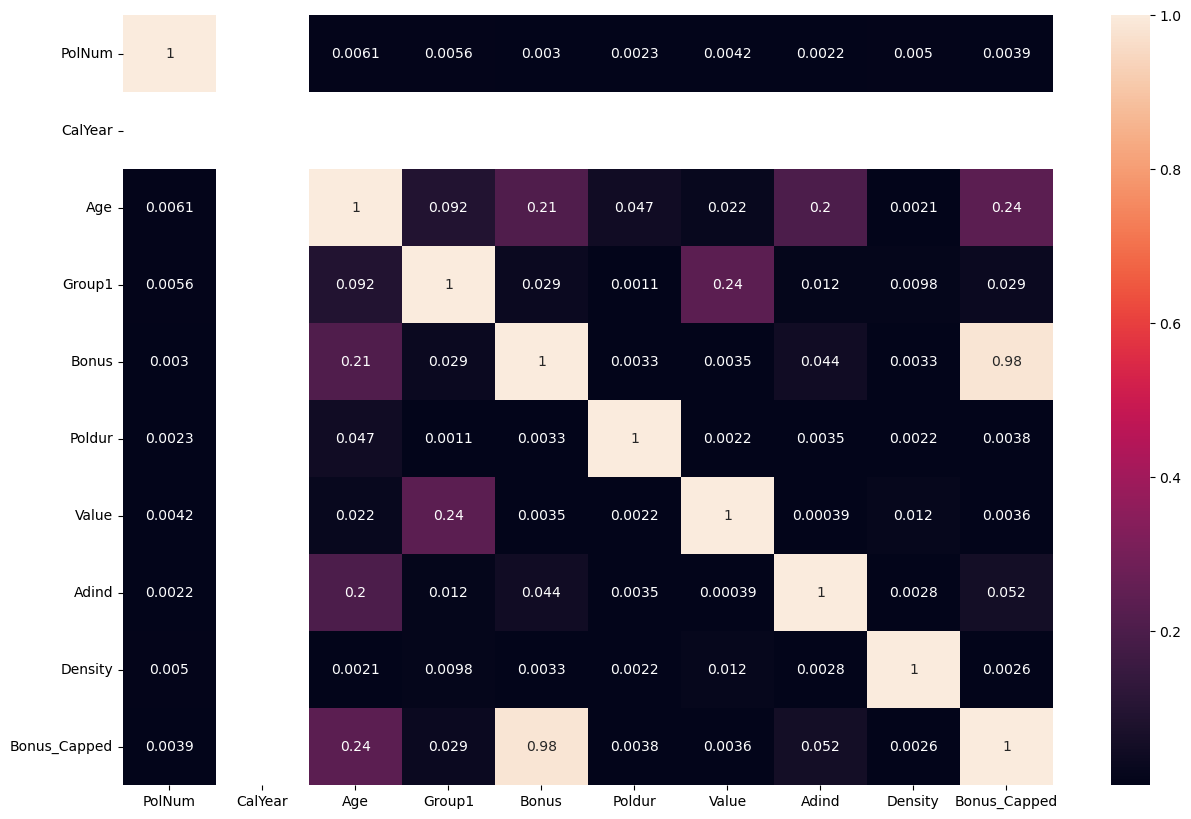

In [25]:
#Continuous and continuous 
numeric_cols = pricing_data.select_dtypes(include=['number'])  # Select only numeric columns
plt.figure(figsize=(15, 10))
sns.heatmap(numeric_cols.corr().abs(), annot=True)
plt.show()


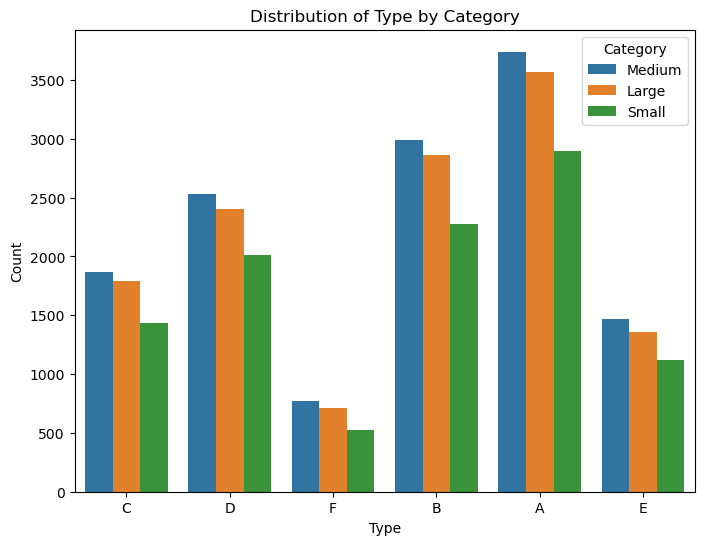

In [26]:
#categorical VS categorical 
plt.figure(figsize=(8, 6))
sns.countplot(x='Type', hue='Category', data=pricing_data)
plt.title('Distribution of Type by Category')
plt.xlabel('Type')
plt.ylabel('Count')
plt.legend(title='Category')
plt.show()

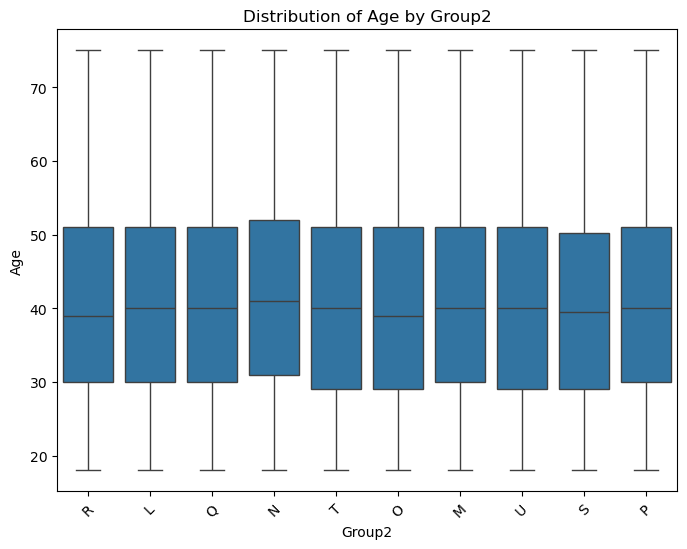

In [28]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Group2', y='Age', data=pricing_data)
plt.title('Distribution of Age by Group2')
plt.xlabel('Group2') #groupe 2 represents the drivers'home region
plt.ylabel('Age')
plt.xticks(rotation=45)
plt.show()

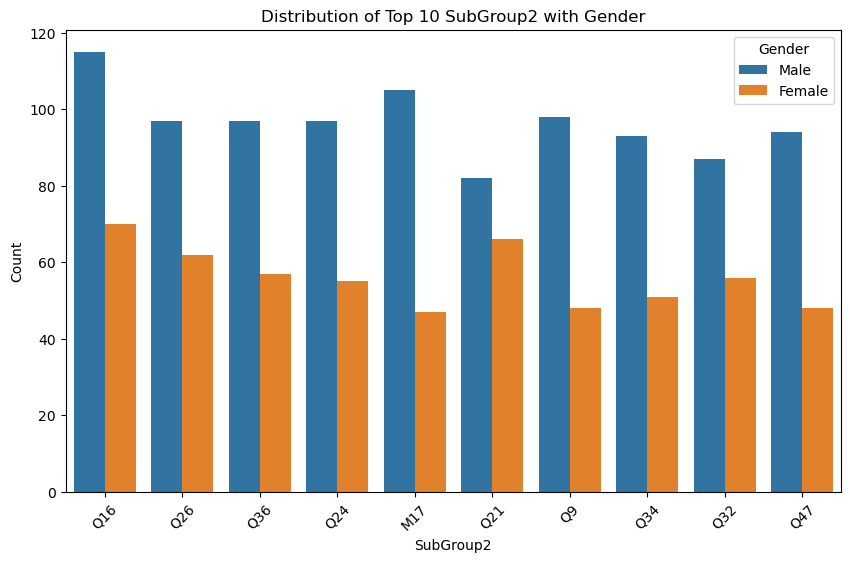

In [29]:
# Get the top 10 categories in 'SubGroup2'
top_subgroup2 = pricing_data['SubGroup2'].value_counts().nlargest(10).index #recall : SubGroup2: Driver's home sub-region.

# Filter the dataset for the top 10 categories
top_subgroup2_data = pricing_data[pricing_data['SubGroup2'].isin(top_subgroup2)] 

# Create the count plot with hue as 'Gender'
plt.figure(figsize=(10, 6))
sns.countplot(x='SubGroup2', hue='Gender', data=top_subgroup2_data, order=top_subgroup2)
plt.title('Distribution of Top 10 SubGroup2 with Gender')
plt.xlabel('SubGroup2')
plt.ylabel('Count')
plt.legend(title='Gender')
plt.xticks(rotation=45)
plt.show()


For the categorical variables, we will need all our variables which are : 
Gender
Type
Category
Occupation
  
Except the variables group 2 and subGroup2, as the information of the drivers' home region is irrelevant for the estimation of the premium value. 

For the numerical variables, we will need : (as the below variables may have an impact on premium costs.)

PolNum     
Age    
Poldur   
Value  
Adind  
Density
Bonus_Capped 

Target variable can be : 
Value
: 19.8+ MB
